In [1]:
import numpy as np
import pandas as pd
from datetime import date
import time
import scipy
import scipy.signal
import os, os.path
import matplotlib
import matplotlib.pyplot as plt


import sys
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/NASA/Python_codes/')
import NASA_core as nc
# import NASA_plot_core.py as rcp

In [2]:
idx="EVI"
data_dir = "/Users/hn/Documents/01_research_data/NASA/VI_TS/05_SG_TS/"

In [3]:
file_names = ["SG_Walla2015_EVI_JFD.csv", "SG_AdamBenton2016_EVI_JFD.csv", 
              "SG_Grant2017_EVI_JFD.csv", "SG_FranklinYakima2018_EVI_JFD.csv"]

data=pd.DataFrame()

for file in file_names:
    curr_file=pd.read_csv(data_dir + file)
    curr_file['human_system_start_time'] = pd.to_datetime(curr_file['human_system_start_time'])
    
    # These data are for 3 years. The middle one is the correct one
    all_years = sorted(curr_file.human_system_start_time.dt.year.unique())
    if len(all_years)==3 or len(all_years)==2:
        proper_year = all_years[1]
    elif len(all_years)==1:
        proper_year = all_years[0]

    curr_file = curr_file[curr_file.human_system_start_time.dt.year==proper_year]
    data=pd.concat([data, curr_file])

data.reset_index(drop=True, inplace=True)
data.head(2)

,ID,human_system_start_time,EVI
0,135073_WSDA_SF_2015,2015-01-10,0.054429
1,135073_WSDA_SF_2015,2015-01-20,0.051731


In [4]:
crr_fld=data[data.ID==data.ID.unique()[0]].copy()
SFYr = crr_fld.human_system_start_time.dt.year.unique()[0]

In [5]:
fine_granular_table = nc.create_calendar_table(SF_year = SFYr)
fine_granular_table = pd.merge(fine_granular_table, crr_fld, on=['human_system_start_time'], how='left')

fine_granular_table.ID = crr_fld.ID.unique()[0]
# replace NAs with -1.5. Because, that is what the function fill_theGap_linearLine()
# uses as indicator for missing values
fine_granular_table.fillna(value={idx:-1.5}, inplace=True)
fine_granular_table.head(2)

,human_system_start_time,doy,ID,EVI
0,2015-01-01,1,135073_WSDA_SF_2015,-1.5
1,2015-01-02,2,135073_WSDA_SF_2015,-1.5


In [6]:
fine_granular_table = nc.fill_theGap_linearLine(a_regularized_TS=fine_granular_table, 
                                                V_idx=idx)

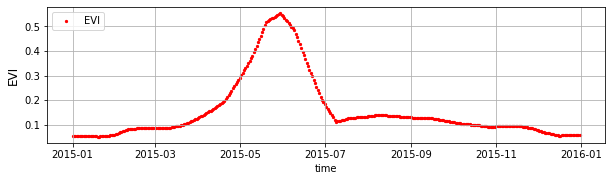

In [7]:
fig, ax = plt.subplots();
fig.set_size_inches(10, 2.5)
ax.grid(True);
ax.scatter(fine_granular_table['human_system_start_time'], fine_granular_table[idx], 
           marker='o', s=5, c='r', label=idx)

ax.set_xlabel('time'); # , labelpad = 15
ax.set_ylabel(idx, fontsize=12); # , labelpad = 15
ax.tick_params(axis = 'y', which = 'major');
ax.legend(loc = "upper left");

# Discretize

In [8]:
import math
epsilon = 2*math.ulp(1.0)

fine_granular_table[fine_granular_table[idx]<0][idx]=0 # Set negatives to zero
fine_granular_table[fine_granular_table[idx]==1][idx]= 1-epsilon # Avoid having 1 to avoid problem

In [9]:
y_bin_size = 0.01
number_of_rows = int(1/y_bin_size)
n_bins = number_of_rows

n_bins = number_of_rows

"""
  The following two lines works for EVI/NDVI, but not generally.
  It works when we are binning [0, 1]
     v = np.array([1, 2, 3, 4, 5])
     n_bins = 5
     ones_indices = np.floor(v * n_bins)
     ones_indices = list((ones_indices).astype(int))
     M = np.zeros((len(v), n_bins))
     M[np.arange(len(v)), ones_indices] = 1
"""
# ones_indices = np.floor(fine_granular_table[idx] * n_bins)
# ones_indices = list((ones_indices).astype(int))

ones_indices = list(pd.cut(x=fine_granular_table[idx], bins=np.arange(0, 1, y_bin_size), labels=False))

image_matrix = np.zeros((n_bins, len(fine_granular_table[idx])))
image_matrix[ones_indices, np.arange(len(fine_granular_table[idx]))] = 1

In [10]:
# M[np.arange(len(v)), ones_indices] = 1
# n_bins = number_of_rows
# v = fine_granular_table[idx]
# ones_indices = np.floor(v * n_bins)
# ones_indices = list((ones_indices).astype(int))

# M = np.zeros((len(v), n_bins))
# M[np.arange(len(v)), ones_indices] = 1

In [11]:
# v = np.array([.1, .2, .3, .4, .5, .9])
# n_bins = 5
# ones_indices = np.floor(v * n_bins)
# ones_indices = list((ones_indices).astype(int))
# M = np.zeros((len(v), n_bins))

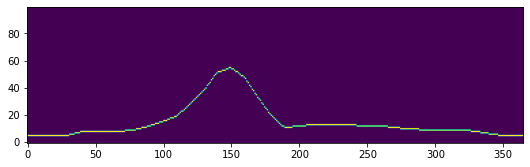

In [12]:
from pylab import imshow
fig, ax = plt.subplots();
fig.set_size_inches(10, 2.5)
imshow(image_matrix, origin='lower')

In [15]:
# image_matrix3D = np.tile(image_matrix,(3, 1, 1))

### Plot 3D verson of the image_matrix

TypeError: Invalid shape (3, 100, 365) for image data

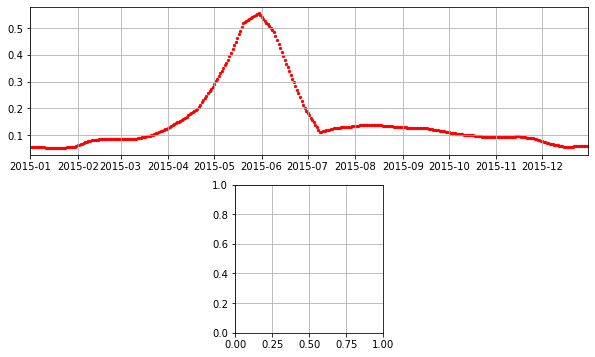

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6),
                        gridspec_kw={'hspace': 0.2, 'wspace': .1});

(ax1, ax2) = axs;
ax1.grid(True); ax2.grid(True)

ax1.scatter(fine_granular_table['human_system_start_time'], fine_granular_table[idx], 
            marker='o', s=5, c='r', label=idx);
left = fine_granular_table['human_system_start_time'][0]
right = fine_granular_table['human_system_start_time'].values[-1]
ax1.set_xlim([left, right]) # the following line alsow orks


ax2.imshow(image_matrix3D, origin='lower');

# plt.tight_layout()
# Make space for title
plt.subplots_adjust(top=0.85)
plt.show()

# Read Training Set Labels

In [ ]:
training_set_dir = "/Users/hn/Documents/01_research_data/NASA/training_set_data/"
train_labels = pd.read_csv(training_set_dir+"train_labels.csv")
train_labels.head(2)

In [ ]:
# # define cnn model
# def define_model():
#     # load model
#     model = VGG16(include_top=False, input_shape=(224, 224, 3))

#     # mark loaded layers as not trainable
#     for layer in model.layers:
#         layer.trainable = False
    
#     # add new classifier layers
#     flat1 = Flatten()(model.layers[-1].output)
#     class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
#     output = Dense(1, activation='sigmoid')(class1)
    
#     # define new model
#     model = Model(inputs=model.inputs, outputs=output)
    
#     # compile model
#     opt = SGD(lr=0.001, momentum=0.9)
#     model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
#     return model

In [ ]:
# vgg16 model used for transfer learning on the dogs and cats dataset
import sys
from matplotlib import pyplot
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
# from keras.optimizers import SGD

from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten

# from keras.optimizers import gradient_descent_v2
# SGD = gradient_descent_v2.SGD(...)

from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator



In [ ]:
# plot dog photos from the dogs vs cats dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
train_folder = '/Users/hn/Documents/01_research_data/dogs-vs-cats/train/'
test_folder = "/Users/hn/Documents/01_research_data/dogs-vs-cats/test1/"
# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # define filename
    filename = train_folder + 'dog.' + str(i) + '.jpg'
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

In [ ]:
from keras.preprocessing.image import load_img
photo = load_img(train_folder + 'dog.' + str(0) + '.jpg', target_size=(200, 200))
print (photo.size)
photo